In [15]:
import airfoils as af
import matplotlib.pyplot as plt
import numpy as np
import potential as pot
from wing import Wing


# Airfoil

(-0.05, 1.05, -0.049713357925077785, 0.12146580378039586)

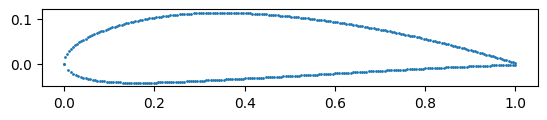

In [16]:
airfoil = af.Airfoil.NACA4("4415", n_points=200)
af_xs, af_ys = airfoil.all_points
plt.scatter(af_xs, af_ys, 1)
plt.axis('scaled')

# Wing Geometry

In [17]:
def linSpan(sp, Ni):
    return np.linspace(0, sp, Ni)


def uniformChord(Ni, ch=1):
    return ch * np.ones(Ni)


In [18]:
N = 20
M = 20
wg = Wing(
    airfoil=airfoil,
    isSymmetric=True,
    span=6,
    alpha=5,
    beta=0,
    Ni=N,
    Nj=M,
    sweepOffset=0,
    dihAngle=0,
    chordFun=uniformChord,
    spanFun=linSpan
)
# wg.plotgrid()


## Wind

In [19]:
Umag = 20
dens = 1.225
Uinf = Umag * np.cos(wg.alpha) * np.cos(wg.beta)
Vinf = Umag * np.cos(wg.alpha) * np.sin(wg.beta)
Winf = Umag * np.sin(wg.alpha) * np.cos(wg.beta)
Q = np.array((Uinf, Vinf, Winf))


## Solve

In [20]:
a_np = np.zeros(((N-1)*(M-1), (N-1)*(M-1)))
b_np = np.zeros(((N-1)*(M-2), (N-1)*(M-2)))
RHS_np = np.zeros((N-1)*(M-1))

for i in np.arange(0, (N-1)*(M-1)):
    lp, kp = divmod(i, (M-1))
    if kp == M-2:
        RHS_np[i] = 0
        a_np[i, i] = 1
        a_np[i, i-1] = -1
        continue
    RHS_np[i] = - np.dot(Q, wg.control_nj[lp, kp])
    for j in np.arange(0, (N-1)*(M-1)):
        l, k = divmod(j, (M-1))
        if k == M-2:
            U, Ustar = pot.voring(wg.controlP[lp, kp, 0],
                                wg.controlP[lp, kp, 1],
                                wg.controlP[lp, kp, 2],
                                l, k, wg.grid)
        else:
            U, Ustar = pot.voring(wg.controlP[lp, kp, 0],
                                wg.controlP[lp, kp, 1],
                                wg.controlP[lp, kp, 2],
                                l, k, wg.grid)

            l1, k1 = divmod(i, (M-2))
            l2, k2 = divmod(j, (M-2))
            b_np[l1*(M-2) -lp  + k1, l2 *(M-2) -l + k2] = np.dot(Ustar, wg.control_nj[lp, kp])

        a_np[i, j] = np.dot(U, wg.control_nj[lp, kp])

In [21]:
Gammas = np.linalg.solve(a_np, RHS_np)
Gammas_mat = Gammas.reshape((N-1, M-1))[:, :-1]
Gammas = Gammas_mat.reshape(((N-1)*(M-2)))
w = np.matmul(b_np, Gammas)
w_mat = w.reshape((N-1, M-2))

In [22]:
L_pan = np.zeros((N-1, M-2))
D_pan = np.zeros((N-1, M-2))
for i in np.arange(0, N-1):
    for j in np.arange(0, M-2):
        dy = wg.grid[i+1, j, 1] - wg.grid[i, j, 1]
        if j == 0:
            g = (Gammas_mat[i, j+1] - Gammas_mat[i, j])
        else:
            g = (Gammas_mat[i, j] - Gammas_mat[i, j-1])
        L_pan[i, j] = dens * Umag * dy * g
        D_pan[i, j] = -0.5 * dens * w_mat[i, j] * dy * g

In [23]:
L = np.sum(L_pan)
D = np.sum(D_pan)
print(f"Using No Penetration\nL:{L}\t|\tD:{D}")
print(f"CL:{L/(dens*(Umag**2)*wg.wingArea)}\t|\tCD_ind:{D/(dens*(Umag**2)*wg.wingArea)}")


Using No Penetration
L:914.1079305412828	|	D:112.28700523085537
CL:0.3109210648099601	|	CD_ind:0.03819285892205965


In [24]:
Dnew = np.zeros((N-1, M-2))
Gammas = np.linalg.solve(a_np, RHS_np)
Gammas_mat = Gammas.reshape((N-1, M-1))

for i in np.arange(0, N-1):
    for j in np.arange(0, M-2):
        dy = wg.grid[i+1, j, 1] - wg.grid[i, j, 1]
        if j == 0:
            g = (Gammas_mat[i, j+1] - Gammas_mat[i, j])
        else:
            g = (Gammas_mat[i, j] - Gammas_mat[i, j-1])
        U = 0
        _, Ui = wg.InducedVelocities(pot.voring,i,j,Gammas_mat)
        
        alfi = Ui[2] / Umag
        Dnew[i,j] = -dens * dy * Umag * g * alfi
D = np.sum(Dnew)
print(f"Using No Penetration\nL:{L}\t|\tD:{D}")
print(f"CL:{L/(dens*(Umag**2)*wg.wingArea)}\t|\tCD_ind:{D/(dens*(Umag**2)*wg.wingArea)}")


Using No Penetration
L:914.1079305412828	|	D:32.75425589243821
CL:0.3109210648099601	|	CD_ind:0.0111409033647749
